In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  


In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt
import csv  
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from operations.fetch_data import PriceHistory
from keys.all_keys import alpha_vantage_api_key

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

API call to collect data

In [4]:
api_key = alpha_vantage_api_key
symbols = {
        'tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'],
        'finance': ['JPM', 'BAC', 'WFC'],
        'etfs': ['SPY', 'QQQ', 'VTI']
    }

number_of_symbols = len(symbols)
path = 'C:/projects/Son_of_anton/data/stocks.csv'
if not pathlib.Path(path).exists():
    price_history = PriceHistory(api_key=api_key, symbols=symbols)
    all_symbols = price_history.symbols()
    print("All symbols:", all_symbols)
    # Build URL example
    url = price_history.build_URL('AAPL')
    print("URL:", url)
    
    
    # Build unified dataframe (will use class symbols if none provided)
    unified_df = price_history.build_df()
    
    
    unified_df.to_csv(path)
    
    # Get summary
    summary = price_history.get_data_summary()
    print("Data Summary:", summary)

In [5]:
df = pd.read_csv('C:\projects\Son_of_anton\data\stocks.csv')
df.head()


,Unnamed: 0,date,open,high,low,close,volume,symbol,daily_return,price_range,avg_price
0,0,1999-11-01,80.00,80.69,77.37,77.62,2487300,AAPL,NaN,3.32,78.560000
1,1,1999-11-02,78.00,81.69,77.31,80.25,3564600,AAPL,0.033883,4.38,79.750000
2,2,1999-11-03,81.62,83.25,81.00,81.50,2932700,AAPL,0.015576,2.25,81.916667
3,3,1999-11-04,82.06,85.37,80.62,83.62,3384700,AAPL,0.026012,4.75,83.203333
4,4,1999-11-05,84.62,88.37,84.00,88.31,3721500,AAPL,0.056087,4.37,86.893333


In [6]:
# grab the cols we need
price_df = df[['date', 'symbol', 'close']]


#pivot the df to make the symbols the headers
price_df = price_df.pivot(
    index= 'date',
    columns='symbol',
    values='close'
)

price_df


symbol,AAPL,AMZN,BAC,GOOGL,JPM,MSFT,QQQ,SPY,VTI,WFC
date,,,,,,,,,,
1999-11-01,77.62,69.13,64.87,NaN,83.56,92.37,130.80,135.5625,NaN,46.88
1999-11-02,80.25,66.44,64.25,NaN,83.69,92.56,130.90,134.5937,NaN,47.38
1999-11-03,81.50,65.81,63.00,NaN,82.44,92.00,133.50,135.5000,NaN,46.13
1999-11-04,83.62,63.06,63.50,NaN,84.12,91.75,135.00,136.5312,NaN,47.00
1999-11-05,88.31,64.94,65.06,NaN,86.25,91.56,136.40,137.8750,NaN,46.81
...,...,...,...,...,...,...,...,...,...,...
2025-06-05,200.63,207.91,44.38,168.21,261.95,467.68,524.79,593.0500,291.72,74.90
2025-06-06,203.92,213.57,44.97,173.68,265.73,470.38,529.92,599.1400,295.12,76.33
2025-06-09,201.45,216.98,44.87,176.09,266.74,472.75,530.70,599.6800,295.36,76.46


In [23]:
# calculate the log return
log_return = np.log(1+price_df.pct_change())
#print('log_return:', log_return)

#calculating the number of symbols
number_of_symbols = len(df['symbol'].unique())

# weights (randomly assigned)
random_weights = np.array(np.random.random(number_of_symbols))
print('random_weights:', random_weights)

#rebalance weights (must be equals to 1)
rebalanced_weights = random_weights/np.sum(random_weights)
print('rebalanced_weights:', rebalanced_weights)

#calc expected Annualized returns (multipiled with 252 for annualization)
exp_returns =  np.sum((log_return.mean()*rebalanced_weights)*252)
print('expected returns:', exp_returns)

#calc expected volality annualized
exp_volt = np.sqrt(np.dot(rebalanced_weights.T,
                          np.dot(log_return.cov()*252,
                                 rebalanced_weights)))
print('exp_volt:', exp_volt)

#cal the sharp ratio
risk_free_rate = 0.03 # us tresury yield 2025
print('r_f:', risk_free_rate)

sharp_ratio = (exp_returns-risk_free_rate)/exp_volt 
print('sharp_ratio:', sharp_ratio)




random_weights: [0.00436095 0.84698166 0.58224532 0.16980758 0.9024383  0.6463609
 0.06856309 0.3278479  0.29245219 0.76875353]
rebalanced_weights: [0.00094602 0.18373456 0.12630567 0.03683612 0.19576469 0.14021417
 0.0148733  0.07111959 0.06344125 0.16676464]
expected returns: 0.03571843447988261
exp_volt: 0.30066738355905265
r_f: 0.03
sharp_ratio: 0.01901913806609982


Monte Carlo Simulation for Optimization

In [24]:
num_of_portfolios = 20000

# Weight array of numpy zeros
weights_arr = np.zeros((num_of_portfolios, number_of_symbols))

# return array
return_arr = np.zeros(num_of_portfolios)

#voletality array
vol_arr = np.zeros(num_of_portfolios)

# sharp ratio array
sharp_ratio_arr = np.zeros(num_of_portfolios)



In [25]:
# Portfolio simulation loop
for index in range(num_of_portfolios):
    # calc the weights
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights/np.sum(weights)

    # add the weights to the weights array
    weights_arr[index, :] = weights

    # calc the expected log returns
    return_arr[index] = np.sum((log_return.mean() * weights) * 252)

    # calc the volatility and add to the vol_arr
    vol_arr[index] = np.sqrt(
        np.dot(weights.T, 
               np.dot(log_return.cov() * 252, weights))
    )

    # sharp ratio - FIXED: use vol_arr[index] instead of vol_arr
    # Also add check to avoid division by zero
    if vol_arr[index] != 0:
        sharp_ratio_arr[index] = (return_arr[index] - risk_free_rate) / vol_arr[index]
    else:
        sharp_ratio_arr[index] = 0  # or np.nan if you prefer

# combine them all together
simulation_data = [return_arr, vol_arr, sharp_ratio_arr, weights_arr]

# new df from the master array
simulation_df = pd.DataFrame(data=simulation_data).T

# add the col names
simulation_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',  
    'Portfolio Weights'
]

# making sure the datatype is correct; don't want floats to be integers
simulation_df = simulation_df.infer_objects()



In [26]:
print('')
print('=' * 250)
print('Simulation Results')  
print('-' * 250)
print(simulation_df.head())
print('-' * 250)


Simulation Results
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                                                                                                                                                     Portfolio Weights
0  0.034423    0.269740      0.016397     [0.10202366704993103, 0.1099909166333975, 0.15321451449968357, 0.023416551965575363, 0.01031833645244717, 0.13780604933368362, 0.05871971288119267, 0.1341398043042325, 0.10074547266651862, 0.16962497421333794]
1  0.039081    0.299854      0.030283  [0.09846735604807319, 0.16314020721470476, 0.042417816536619135, 0.16044251632384346, 0.15623170083428753, 0.004938033313619574, 0.15339224236737395, 0.06850054240183122, 0.0864905945958

In [30]:
# grab the max sharpe ratio
max_sharpe_ratio = simulation_df.loc[simulation_df['Sharpe Ratio'].idxmax()]

# min volatility
min_vol = simulation_df.loc[simulation_df['Volatility'].idxmin()]

print('')
print('=' * 250)
print('Max sharpe ratio:')  
print('-' * 250)
print(max_sharpe_ratio)
print('-' * 250)

print('')
print('=' * 250)
print('Min volatility:')  
print('-' * 250)
print(min_vol)
print('-' * 250)


Max sharpe ratio:
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Returns                                                                                                                                                                                                                         0.05214
Volatility                                                                                                                                                                                                                     0.238822
Sharpe Ratio                                                                                                                                                                                                                   0.092705
Portfolio Weights    [0.0332683806

Ploting

C:\Users\abdul\AppData\Local\Temp\ipykernel_10284\3559206542.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\abdul\AppData\Local\Temp\ipykernel_10284\3559206542.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\abdul\AppData\Local\Temp\ipykernel_10284\3559206542.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_vol[1],
C:\Users\abdul\AppData\Local\Temp\ipyker

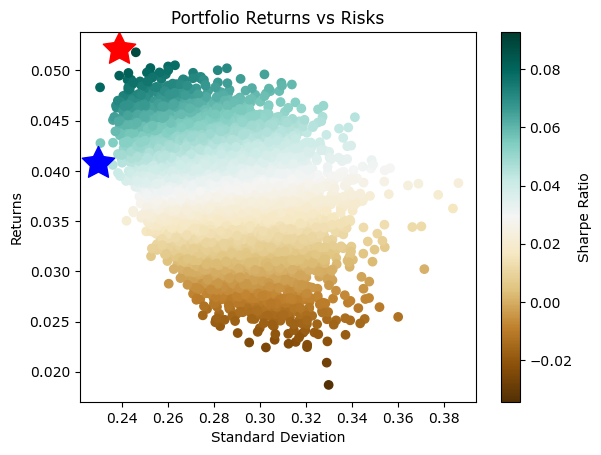

In [35]:
# data in a scatter plot
plt.scatter(
    y=simulation_df['Returns'],
    x=simulation_df['Volatility'],
    c=simulation_df['Sharpe Ratio'],
    cmap='BrBG'
)

plt.title('Portfolio Returns vs Risks')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# max sharp ratio -> red star
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5,1,0),
    color='r',
    s=600
)

# min volatility ratio -> blue star
plt.scatter(
    min_vol[1],
    min_vol[0],
    marker=(5,1,0),
    color='b',
    s=600
)

plt.show()

C:\Users\abdul\AppData\Local\Temp\ipykernel_10284\2827790262.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\abdul\AppData\Local\Temp\ipykernel_10284\2827790262.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\abdul\AppData\Local\Temp\ipykernel_10284\2827790262.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_vol[1],
C:\Users\abdul\AppData\Local\Temp\ipyker

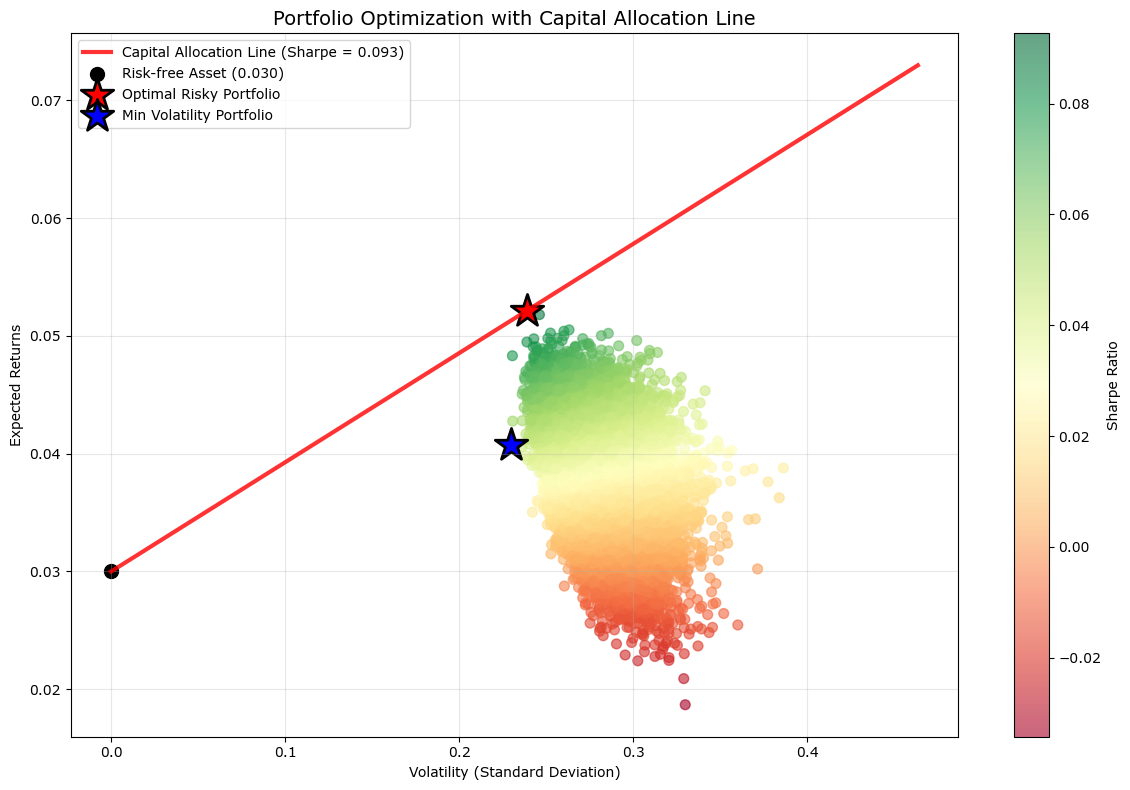

In [ ]:

# the indifference curve for the maximum Sharpe ratio
plt.figure(figsize=(12, 8))

# Portfolio scatter plot
scatter = plt.scatter(
    x=simulation_df['Volatility'],
    y=simulation_df['Returns'],
    c=simulation_df['Sharpe Ratio'],
    cmap='RdYlGn',
    alpha=0.6,
    s=50
)

plt.title('Portfolio Optimization with Capital Allocation Line', fontsize=14)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')

# Capital Allocation Line (CAL) - the line tangent to efficient frontier
max_sharpe_value = simulation_df['Sharpe Ratio'].max()
vol_range = np.linspace(0, simulation_df['Volatility'].max() * 1.2, 100)
cal_returns = risk_free_rate + max_sharpe_value * vol_range

plt.plot(vol_range, cal_returns, 
         color='red', 
         linewidth=3,
         label=f'Capital Allocation Line (Sharpe = {max_sharpe_value:.3f})',
         alpha=0.8)

# Risk-free rate point
plt.scatter(0, risk_free_rate, 
           marker='o', 
           color='black', 
           s=100,
           label=f'Risk-free Asset ({risk_free_rate:.3f})')

# Max Sharpe ratio portfolio
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker='*',
    color='red',
    s=600,
    edgecolor='black',
    linewidth=2,
    label='Optimal Risky Portfolio'
)

# Min volatility portfolio
plt.scatter(
    min_vol[1],
    min_vol[0],
    marker='*',
    color='blue',
    s=600,
    edgecolor='black',
    linewidth=2,
    label='Min Volatility Portfolio'
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()